# Classifier

## Importing Relevant Libraries

In [68]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
import seaborn as sns
import random
import torch.cuda
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.linalg import svd
import seaborn as sns
from sklearn.impute import KNNImputer
from IPython.display import display, clear_output

# Define Classes

In [69]:
class Linear_QNet(nn.Module):
    def __init__(self, inputs):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.linear1 = nn.Linear(inputs, 256)
        self.linear2 = nn.Linear(256,512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256,2)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = F.tanh(self.linear4(x))
        return x
    
    def save(self, file_name='model.pth', index=0):
        model_folder_path = './Classifier_models/model' 
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        complete_file_name = f"{index}_{file_name}"
        file_path = os.path.join(model_folder_path, complete_file_name)
        
        torch.save(self.state_dict(), file_path)
    
class QTrainer:
    def __init__(self, model, lr):
        self.lr = lr
        self.model = model
        self.device = model.device
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, done, outcome):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
        action = torch.tensor(np.array(action), dtype=torch.long).to(self.device)
        reward = torch.tensor(np.array(reward), dtype=torch.float).to(self.device)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)
        target = pred.clone()
        
        if outcome[0].item() == 1:
            target[0,0] = 1
            target[0,1] = 0
        else:
            target[0,0] = 0
            target[0,1] = 1

        self.optimizer.zero_grad()
        
        ## Calculate MSE loss on target and prediction
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


## Agent tager filepath som input hvis man vil køre en model, der allerede er trænet.
class Agent:
    def __init__(self, inputs, file_path=None, training=True, device=None, 
                 learning_rate=0.01, model_name='testing', data=None):
        self.data = data
        self.MAX_MEMORY = 5_000 ## Længde af buffer
        self.memory = deque(maxlen=self.MAX_MEMORY)  ## popleft() buffer
        self.BATCH_SIZE = 32 ## Sample størrelse
        self.LR = learning_rate ## Learning rate (TIDLIGERE 0.01 for onestep)
        if device is not None: ## Her kan man vælge at køre cpu selvom man har cuda
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        inputs = inputs + len(self.data.T) -1
        self.model = Linear_QNet(inputs=inputs).to(self.device) 
        self.model_name = model_name

        ## Definerer en masse variable baseret på __init__ input
        self.is_training = training
        self.file_path = file_path

        ## Hvis vi har en sti til en model, vil vi loade den i stedet for at træne en ny
        if self.file_path is not None:
            self.model.load_state_dict(torch.load(self.file_path, map_location=self.device))
            self.model.eval()

        ## Initialisér trainer
        self.trainer = QTrainer(self.model, lr=self.LR)


        ## Gemmer state-actionpar til buffer
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        ## Træner long memory
    def train_long_memory(self):
        if len(self.memory) > self.BATCH_SIZE:
            mini_sample = random.sample(self.memory, self.BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones, self.target_model)

        ## Træner short memory
    def train_short_memory(self, state, action, reward, done, outcome):
        self.trainer.train_step(state, action, reward, done, outcome)

        ## Bestem en action
    def get_action(self, state):

        final_move = torch.tensor([0,0])

        ## Laver state om til tensor og får en prediction fra modellen
        state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).clone().detach()
        prediction = self.model(state_tensor)

        ## Vælger den class med højeste værdi
        move = torch.argmax(prediction).item()
        final_move[move] = 1

        return final_move
    
    def train(self, rounds, pcs, loading=False, evaluating=False):
        accur = np.zeros(rounds)
        lower_acc = np.zeros(rounds)
        upper_acc = np.zeros(rounds)
        pos_accuracy = np.zeros(rounds)
        neg_accuracy = np.zeros(rounds)
        pos_outcome_tracker = []
        neg_outcome_tracker = []
        for j in range(rounds):
            res = []
            for i in range(len(self.data)):
                state = self.data[i,:len(self.data.T)-1]
                pc_vals = [pc @ state for pc in pcs]
                state = np.concatenate((state, pc_vals))
                outcome = self.data[i,-1]
                outcome = torch.tensor([1,0] if outcome == 1 else [0,1])
                decision = self.get_action(state)
                reward = 0
                if list(decision) == list(outcome): reward = 1

                if list(outcome) == [1,0]:
                    ## Personen fik diabetes
                    if list(decision) == [1,0]: pos_outcome_tracker.append(1)
                    else: pos_outcome_tracker.append(0)
                else:
                    ## Personen fik ikke diabetes
                    if list(decision) == [0,1]: neg_outcome_tracker.append(1)
                    else: neg_outcome_tracker.append(0)

                if self.is_training: self.train_short_memory(state, decision, reward, done=True, outcome=outcome)
                res.append(reward)

            p_hat = np.mean(res)
            lower, upper =p_hat - 1.96*np.sqrt((p_hat*(1-p_hat))/len(res)), p_hat + 1.96*np.sqrt((p_hat*(1-p_hat))/len(res))

            if j % (rounds/20) == 0 and loading:
                print(f'Loading: {int((j)/rounds*100)}%'*self.is_training,'Mean', round(np.mean(res),2), 
                      'CI:', round(lower,2), round(upper,2))
                
            accur[j] = np.mean(res)
            lower_acc[j], upper_acc[j] = lower, upper
        self.model.save()
        
        if evaluating:
            pos_accuracy[0] = np.mean(pos_outcome_tracker)
            neg_accuracy[0] = np.mean(neg_outcome_tracker)
            return np.concatenate(([accur], [lower_acc], [upper_acc], [pos_accuracy], [neg_accuracy]), axis=0)

        return np.concatenate(([accur], [lower_acc], [upper_acc]), axis=0)

# Handling Data

In [70]:
# Read csv file to pd DataFrame
df = pd.read_csv('diabetes.csv')

# Replace 0's with NaN in columns where 0's are not possible
for col in df.columns:
    if col in ['Pregnancies', 'Outcome']:
        continue
    df[col] = df[col].replace(0, np.nan)

# Remove NaN rows in data
def remove_nan(DataFrame):
    return DataFrame.dropna()

def impute_nan(DataFrame, n=5):
    imputer = KNNImputer(n_neighbors=n)
    imputed_array = imputer.fit_transform(DataFrame)
    imputed_df = pd.DataFrame(data=imputed_array, columns=DataFrame.columns)
    return  imputed_df


## Removing Outliers

In [71]:
def remove_outliers(DataFrame, std_threshold=4):
    # Calculate the mean and standard deviation for each column
    means = DataFrame.mean()
    stds = DataFrame.std()

    # Define threshold as 4 standard deviations from mean
    std_threshold = 4

    # Create boolean DataFrame indicating whether or not observations exceed threshold
    conditions = (DataFrame < (means - std_threshold * stds)) | (DataFrame > (means + std_threshold * stds))

    # Any row that should be removed will have at least one True in the conditions DataFrame
    rows_to_remove = conditions.any(axis=1)

    # Remove the rows that meet the condition
    DataFrame = DataFrame[~rows_to_remove]
    return DataFrame

### Splitting data into k groups

In [72]:
def k_split(DataFrame, k, RemoveOutliers=False, ImputeMissing=False):
    'If not ImputeMissing, NaNs will be removed. NaNs will always be removed in test data.'
    # Shuffle the DataFrame
    shuffled = DataFrame.sample(frac=1)

    # Split into k groups
    groups = np.array_split(shuffled, k)

    X_data = []
    Y_data = []
    pc_array = []
    global features

    for i in range(k):
        groups_copy = groups.copy()
        test_data = groups_copy.pop(i)

        ## We do not want to impute the NaNs on the data, we are using to evaluate the model.
        ## In this case, NaNs will be removed. Outliers will stay - may want to change that.
        test_data = remove_nan(DataFrame=test_data)
        if RemoveOutliers:
            test_data = remove_outliers(DataFrame=test_data)
        test_standard = test_data.loc[:, features].values
        test_standard = StandardScaler().fit_transform(test_standard)
        test_standard = np.column_stack((test_standard, test_data['Outcome']))
        Y_data.append(test_standard)

        training_frames = pd.concat(groups_copy)
        if ImputeMissing:
            training_frames = impute_nan(DataFrame=training_frames)
        else:
            training_frames = remove_nan(DataFrame=training_frames)
        if RemoveOutliers:
            training_frames = remove_outliers(DataFrame=training_frames)
        training_standard = training_frames.loc[:, features].values
        training_standard = StandardScaler().fit_transform(training_standard)
        training_standard = np.column_stack((training_standard, training_frames['Outcome']))
        X_data.append(training_standard)

        ## Perform PCA
        %run pca.ipynb 
        data_drop_outcome = np.array([row[:-1] for row in X_data[i]])
        Vh = get_PCs(data_drop_outcome)
        pc_array.append(Vh)

    return X_data, Y_data, np.array(pc_array)


# Define the cross-validation function

In [73]:
def cross_validate(training_data, test_data, pcs, n_pcs, learning_rate, rtt, plot=False, loading=False):
    print(f'Working on:', 'CUDA' if torch.cuda.is_available() else 'CPU')
    validation_stats = []
    for i in range(len(training_data)):
        X= training_data[i]
        Y = test_data[i]

        components = [pcs[i][j] for j in range(n_pcs)]


        agent = Agent(learning_rate=learning_rate, data=X, inputs=n_pcs)
        training_accuracy = agent.train(rtt, loading=loading, pcs=components)
        if plot:
            sns.lineplot(pd.DataFrame(training_accuracy.T, columns=['Accuracy', 'CI Lower Bound', 'CI Upper Bound']))
            plt.xlabel('Rounds')
            plt.ylabel('Accuracy')
            plt.title('Training Accuracy')

        if loading: print('\nEval')
        agent = Agent(training=False, file_path='Classifier_models/model/0_model.pth', data=Y, inputs=n_pcs)
        final_stats = agent.train(1, loading=loading, pcs=components, evaluating=True)
        final_accuracy, final_lower_bound, final_upper_bound, positive_acc, negative_acc = [stat[0] for stat in final_stats]
        print(i+1,round(final_accuracy,2))
        print('False Negative %', np.round(1-positive_acc,2), 'False Positive %', np.round(1-negative_acc,2),'\n')

        if plot:
            plt.errorbar(x=rtt, y= final_accuracy, yerr=(final_upper_bound-final_lower_bound)/2, elinewidth=1, 
            capsize=10)
            plt.show()
        validation_stats.append(final_stats)
    return validation_stats

c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Working on: CUDA
1 0.86
False Negative % 0.25 False Positive % 0.08 



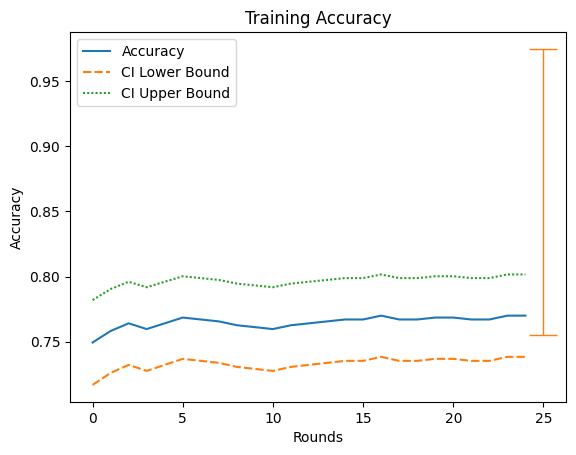

2 0.74
False Negative % 0.46 False Positive % 0.17 



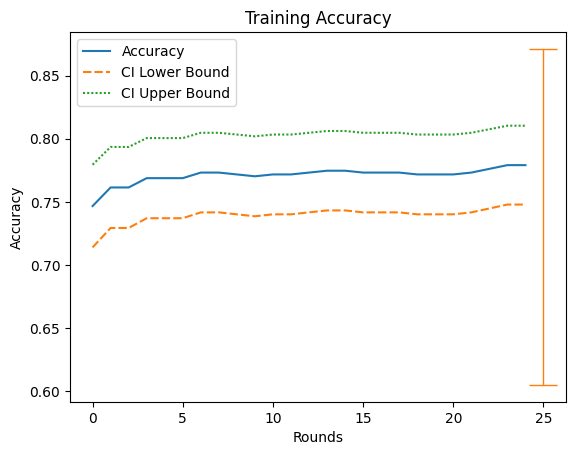

3 0.61
False Negative % 0.55 False Positive % 0.3 



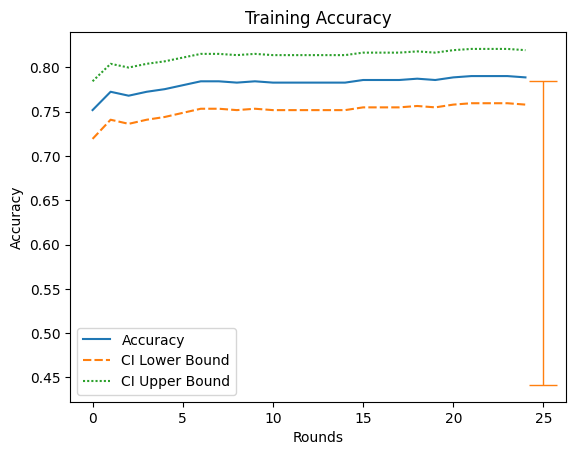

4 0.79
False Negative % 0.38 False Positive % 0.12 



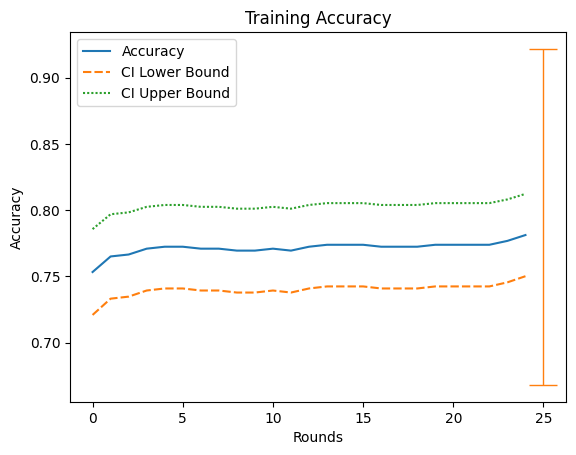

5 0.88
False Negative % 0.23 False Positive % 0.08 



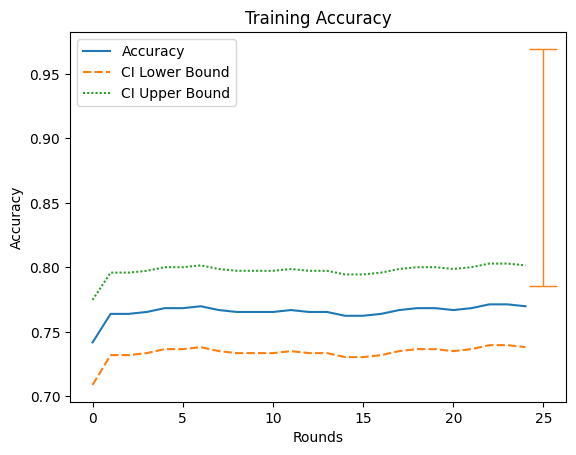

6 0.77
False Negative % 0.53 False Positive % 0.04 



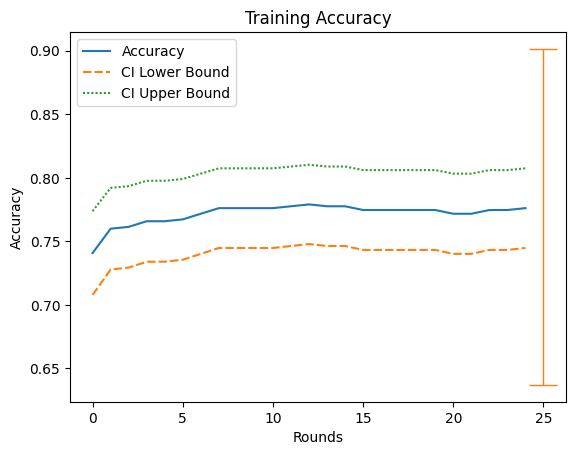

7 0.73
False Negative % 0.38 False Positive % 0.24 



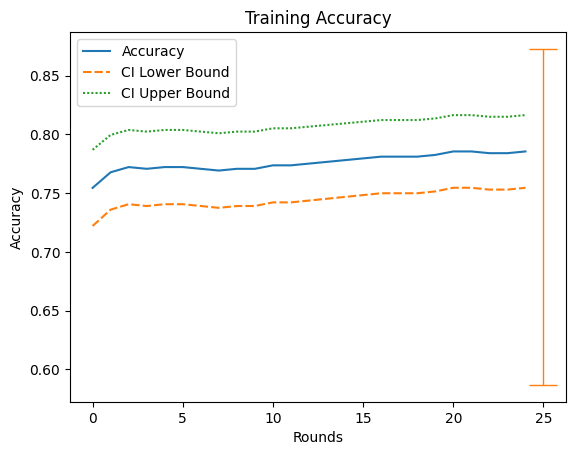

8 0.76
False Negative % 0.4 False Positive % 0.11 



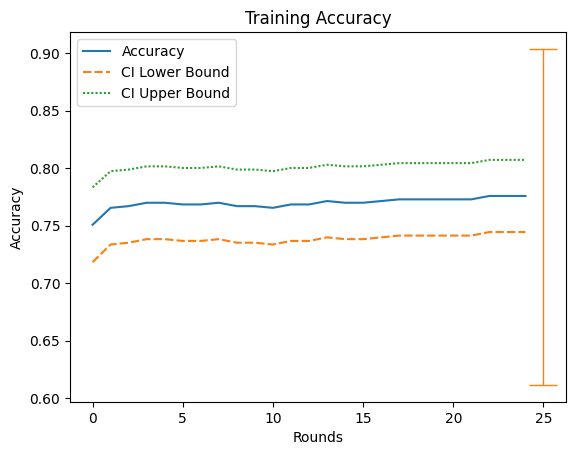

9 0.68
False Negative % 0.53 False Positive % 0.2 



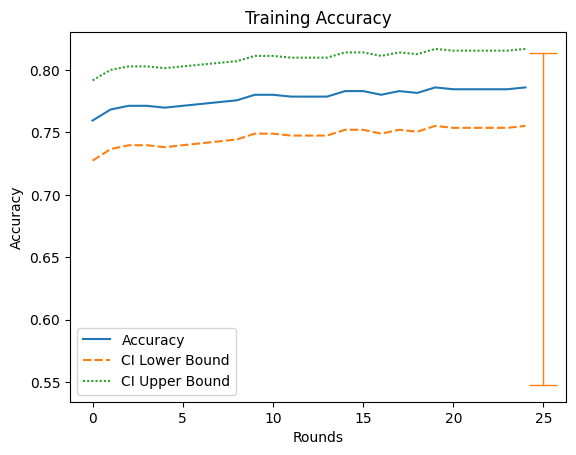

10 0.82
False Negative % 0.3 False Positive % 0.12 



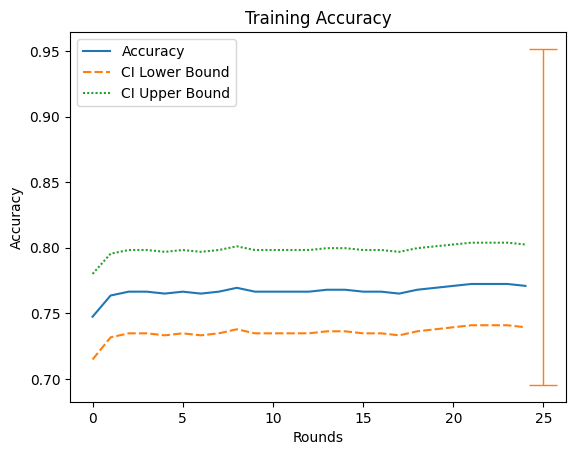

Mean: 0.76 Std 0.08 Min/Max [0.61] [0.88] Mean CI: 0.63 0.9 Mean False Negatives: 0.4 Mean False Positives: 0.15


In [74]:
## Decide on k
k = 10

## How many times to go train on the dataset before evaluating?
rounds_to_train = 25

## How many principal components should be used?
number_of_pcs = 0

## Learning Rate
LR = 0.0001

# Which coloumns to drop when standardizing and giving to model. 'Outcome' should be dropped
# If any other columns shold be dropped (for feature engineering purposes), these can be specified here as well:
drop_coloumns = ['Outcome', 'DiabetesPedigreeFunction']

# Get all remaining columns in lists
features = [col for col in df.columns if col not in [kol for kol in drop_coloumns]]

## Create Data from DataFrame
X_data, Y_data, pc_array = k_split(df, k=k, RemoveOutliers=True, ImputeMissing=True)
X_data, Y_data, pc_array

## Perform cross validation
statistics = cross_validate(X_data,Y_data,pc_array, n_pcs=number_of_pcs, learning_rate = LR, rtt=rounds_to_train, plot=True)

## Analyze the data
means, low_means, high_means, false_negatives, false_positives = [], [], [], [], []
for run_stat in statistics:
    means.append(run_stat[0])
    low_means.append(run_stat[1])
    high_means.append(run_stat[2])
    false_negatives.append(1-run_stat[3])
    false_positives.append(1-run_stat[4])
    
print('Mean:', np.round(np.mean(means),2), 'Std', np.round(np.std(means),2), 'Min/Max', np.round(min(means),2), 
      np.round(max(means),2), 'Mean CI:', np.round(np.mean(low_means),2), np.round(np.mean(high_means),2),
      'Mean False Negatives:', np.round(np.mean(false_negatives),2), 
      'Mean False Positives:', np.round(np.mean(false_positives),2))


# lr 0.0001, 50 runder: Mean 0.83 CI: 0.75 0.92 
# lr 0.0001, 20 runder, pc1 + pc2: Mean 0.85 CI: 0.77 0.93  